# A simple Bayesian analysis of the Infection Fatality Rate in Gangelt, and extrapolation to infection-counts in Germany

Matthias Kümmerer, Philipp Berens, Jakob Macke

## Abstract
We present a simple Bayesian analysis of the infection fatality rate using the data and estimates of infection rate from a recent study in the small town of Gangelt, Germany. Using on our prior- and modelling assumptions, we find a  posterior mean estimate of XY, and a credible interval of (XY to XY). We discuss the dependence of these results on prior assumptions and number of fatalities observed. Finally, we show the uncertainty in the estimatad infection fatality rate would affect an extrapolation to infection counts in Germany Even if the infection fatality rate in Gangelt was the same as in Germany-- any such extrapolation would carry a high degree of variability, yielding infection counts which could vary from XY to XY. These observations highlight the importance of uncertainty quantification in studies which is based on a small number of observed fatalities.

## Introduction

With the coronavirus pandemic rapidly developing across the world, estimates of key epidemiological quantities are in critical demand. Maybe like never before, their estimates inform policy decisions, possibly affecting the lives of many and impacting economies world wide. For that reason, providing accurate estimates of these quantities, as well as reliable uncertainty intervals around those estimates is paramount. 

Among those key quantities are
the infection rate (IR), i.e. the true fraction of infected people in a population, and  
the infection fatality rate (IFR), i.e. the fraction of people who die after infection (including asymptomatic and
The latter needs to be distinguished from the case fatality rate, which is defined as the fraction of people dying after being diagnosed with Sars-Cov-19. 

A recent study from Germany, the so-called [Heinsberg study](https://www.medrxiv.org/content/10.1101/2020.05.04.20090076v1), aimed at estimating the IR and IFR  in a small town called Gangelt in the municipality of Heinsberg, close to Aachen in the west of Germany. This town was hit hard early on in the epidemic due to a super-spreading event caused by Carnival festivities, leading to a (likely) comparably high rate of infected people. While therefore its IR will not be representative for other regions in Germany, it is precisely its high IR which makes it suitable for providing an estimate of the IFR.

The authors combined PCR testing for acute infections and antibody testing, as well as statistical corrections for non-independence among household members and other factors. Among  N=919 participants, they thus estimated an IR of 15.53% (12.31%; 18.96%) (95%CI). Knowing that 7 people with Covid-19-Diagnosis had died in the time frame of the study, they estimated the IFR to be 0.358% (0.293%; 0.451%) (95% CI).
This calculation incorporates uncertainty about the total number of infected people in Gangelt (as the infection count is extrapolated from the tested cases), but not any uncertainty regarding the finite sample of Gangelt as a sample from a larger population.

The authors argue that the observation of 7 deaths in Gangelt is directly observed without error, and therefore does not induce any additional uncertainty. This reasoning could be appropriate if the IFR calculation is exclusively used as a summary statistic describing the data in Gangelt. However, estimates of IFRs are commonly used both in policy-discussions which explicitly or implicitly generalize to regions beyond Gangelt, as well as a means of constraining epidemiological models. Indeed, in the discussion, the authors discuss how their estimated IFR could be used to yield  an estimate of the expected number of infected people in Germany, which they state is at least 1.8 Million people, based on the number of 6757 deaths on May 2nd, 2020. The authors do not provide error bars on this quantity, but rather regard it as a purely theoretical model (for which the error bars on IFR calculated by them would not be valid). 

### Our central questions are:

* How could one provide uncertainty estimates (i.e. error bars) on IFRs in a way that includes both the uncertainty about the IR, as well as the uncertainty arising from the fact that only a finite number of fatalities is observed? 

* How would this uncertainty translate to an uncertainty in the total number of infected people in Germany?  

We show how a Bayesian approach can be used to provide error bars on both the IFR and the number of infected people in Germany, propagating all necessary uncertainties through the inference chain.

We emphasize that we focusely solely on how one could provide uncertainty-estimates on these two quantities with a Bayesian approach -- we do not have the expertise to evaluate the plausibility of the modelling assumptions or the methodology of the study, as discussed below.  



In [1]:
# Setting up necessary packages and environments
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['CXX'] = 'g++'
import pickle
import arviz
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
from IPython.display import display
import scipy.stats.distributions as dist

In [16]:
# some helper functions for computing distribution parameters and for plotting

def beta_a(mean, var):
    assert var < mean*(1-mean)
    
    return mean*(mean*(1-mean)/var-1)

def beta_b(mean, var):
    assert var < mean*(1-mean)
    
    return (1 - mean) * (mean*(1-mean)/var-1)



def format_as_percent(x, round_to=0):
    return "{0:.{1:d}f}%".format(100 * x, round_to)

# extracted from arviz code and adapted to our needs.
def plot_hpd(values, credible_interval=0.95, multimodal=False, ax=None, value_format='{:.02%}'):
    if ax is None:
        ax = plt.gca()
    
    if isinstance(value_format, str):
        value_format = lambda value, format_str=value_format: format_str.format(value)
    
    hpd_intervals = arviz.stats.hpd(
        values, credible_interval=credible_interval, multimodal=multimodal
    )  # type: np.ndarray
    
    plot_base = ax.get_ylim()[0]
    plot_height = ax.get_ylim()[1] - plot_base
    linewidth = 1
    ax_labelsize = 14
    round_to = 3

    for hpdi in np.atleast_2d(hpd_intervals):
        ax.plot(
            hpdi,
            (plot_base + plot_height * 0.02, plot_base + plot_height * 0.02),
            lw=linewidth * 2,
            color="k",
            solid_capstyle="butt",
        )
        ax.text(
            hpdi[0],
            plot_base + plot_height * 0.07,
            value_format(hpdi[0]),
            size=ax_labelsize,
            horizontalalignment="center",
        )
        ax.text(
            hpdi[1],
            plot_base + plot_height * 0.07,
            value_format(hpdi[1]),
            size=ax_labelsize,
            horizontalalignment="center",
        )
        ax.text(
            (hpdi[0] + hpdi[1]) / 2,
            plot_base + plot_height * 0.3,
            format_as_percent(credible_interval) + " HPD",
            size=ax_labelsize,
            horizontalalignment="center",
        )
    point_value = values.mean()
    point_text = 'mean='+value_format(point_value)
    
    ax.text(
        point_value,
        plot_height * 0.8,
        point_text,
        size=ax_labelsize,
        horizontalalignment="center",
    )


def plot_german_infected(values, ax=None):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    ax.hist(values, bins=1000)
    ax.set_xlim(1e5, 5e6)
    plot_hpd(values, value_format=lambda value: '{:.02f}M'.format(value/1e6), ax=ax)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.01f}M'.format(value/1e6)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)
    
def plot_gangelt_infected(values, ax=None):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    ax.hist(values, bins=100)
    ax.set_xlim(1000, 3000)
    plot_hpd(values,
             #value_format=lambda value: '{:d}'.format(value/1e6),
             #value_format='{:d}',
             value_format=lambda value: str(int(value)),
             ax=ax)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.01f}M'.format(value/1e6)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)

def plot_infection_fatality_rate(values, ax=None, show_hpd=True, xlim=(0, 0.015)):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    
    arviz.plot_kde(values, ax=ax, textsize=14)
    if show_hpd:
        plot_hpd(values, value_format=lambda value: '{:.02%}'.format(value), ax=ax)
    
    ax.set_xlim(xlim)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    ax.set_xticks([0.005, 0.01])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.02%}'.format(value)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)
    
    
def plot_infection_fatality_rate_prior(values, ax=None, show_hpd=True):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    
    arviz.plot_kde(values, ax=ax, textsize=14)
    if show_hpd:
        plot_hpd(values, value_format=lambda value: '{:.02%}'.format(value), ax=ax)
    
    #ax.set_xlim(0, 0.4)
    ax.set_xlim(0, 1.0)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    #ax.set_xticks([0.005, 0.01])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.00%}'.format(value)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)
    
    
def plot_infection_rate(values, ax=None):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    
    arviz.plot_kde(values, ax=ax, textsize=14)
    ax.set_xlim(0.1, 0.25)
    plot_hpd(values, value_format=lambda value: '{:.02%}'.format(value), ax=ax)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    ax.set_xticks([0.1, 0.15, 0.2])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.02%}'.format(value)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)

# Our Model:

We concentrate on estimation of the infection fatality rate (IFR) in Gangelt.  In a second step,  we show how one could use the IFR (along with the associated uncertainty) to  extrapolate to infection-counts in Germany, and how big the resulting error bars would be. We emphasize that both of the estimation procedures will depend strongly on the modelling assumptions. We do not attempt to provide an estimate of the infection rate (IR) in Gangelt, but rather directly take the IR-estimate of [Streeck et al 2020](https://www.medrxiv.org/content/10.1101/2020.05.04.20090076v1). (See [this post](https://statmodeling.stat.columbia.edu/2020/05/01/simple-bayesian-analysis-inference-of-coronavirus-infection-rate-from-the-stanford-study-in-santa-clara-county/) for a Bayesian analysis of an infection rate of the Santa-Clara study). In Streeck et al, the infection rate is estimated as 0.1553 with confidence intervals (0.1231, 0.1896). To preserve this uncertainty estimate, we assume the infection rate to follow a Beta distribution with parameters and which are chosen such that this prior has the same mean and variance as the IR estimate from Streeck et al 2020. 

We will then infer a posterior over the infection fatality rate as follows: We model the IR in Gangelt as a beta distribution that captures the reported uncertainty. Given the IR, The number of infections in Gangelt is then modelled as binomially distributed depending on the infection rate and the (fixed) number of individuals in Gangelt. Given the number of infected individuals, the number of fatalities is modelled as bionomially distributed depending on the infection fatality rate and the number of infections with a weak beta prior in the infection fatality rate. After computing the posterior over the infection fatality rate, we will model the infections in Germany as a negative binomial distribution depending on the infection fatality rate and the number of fatalities in Germany. (See below for a more detailed description of the model)

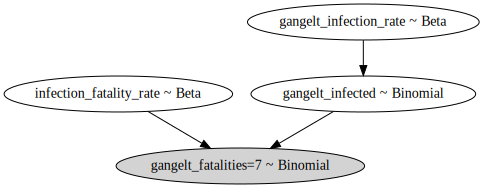

In [19]:
with pm.Model() as model:
    # compute beta parameters from estimate and CI in paper: 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate_mean = 0.1553
    gangelt_infection_rate_sd = (0.1896-0.1231)/4  # the paper states a 95%CI of [0.1231, 0.1896]
    gangelt_infection_a = beta_a(mean=gangelt_infection_rate_mean, var=gangelt_infection_rate_sd**2)
    gangelt_infection_b = beta_b(mean=gangelt_infection_rate_mean, var=gangelt_infection_rate_sd**2)
    
    gangelt_infection_rate = pm.Beta(alpha=gangelt_infection_a, beta=gangelt_infection_b, name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    ifr_prior_a = beta_a(mean=0.1, var=0.1**2)
    ifr_prior_b = beta_a(mean=0.1, var=0.1**2)
    infection_fatality_rate = pm.Beta(alpha=ifr_prior_a, beta=ifr_prior_b, name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

display(pm.model_graph.model_to_graphviz(model))

### Inspecting the priors


In [4]:
if os.path.isfile('model1_prior.pydat'):
    prior = pickle.load(open('model1_prior.pydat', 'rb'))
else:
    with model:
        prior = pm.sample_prior_predictive(samples=50000)
    with open('model1_prior.pydat', 'wb') as f:
        pickle.dump(prior, f)

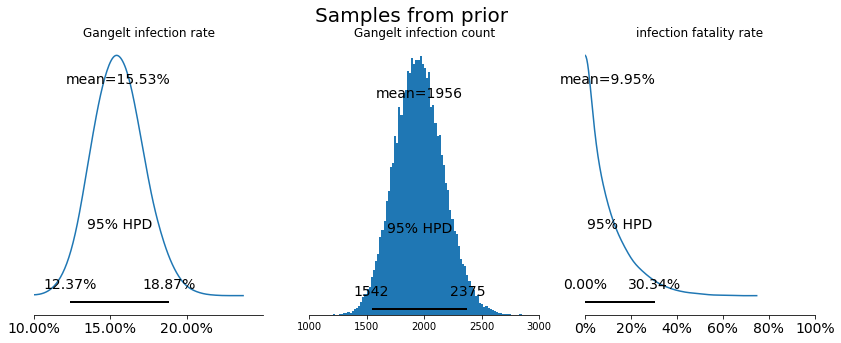

In [18]:
f, axs = plt.subplots(1, 3, figsize=(14, 5))

plot_infection_rate(prior['gangelt_infection_rate'], ax=axs[0])
plot_gangelt_infected(prior['gangelt_infected'], ax=axs[1])
plot_infection_fatality_rate_prior(prior['infection_fatality_rate'], ax=axs[2])


axs[0].set_title('Infection Rate (IR) in Gangelt')
axs[2].set_title('Infection Fatality Rate (IFR)')
axs[1].set_title('Infection Count in Gangelt')

f.suptitle('Samples from prior', fontsize=20);

We first visualize the priors: As intended, the prior over the IR has pretty much the same confidence interval as the one stated the Gangelt-study (0.1553 [0.1231, 0.1896].) By sampling infections (using a binomial distribution, i.e. assuming that infections are independent from each other), we also obtain a prior over infection counts which is consistent with the statement in the Gangelt study. 

For the IFR, we chose to use a prior which has a mean of 10%, but still assigns probability to higher IFRs, reflecting our expectations that the IFR will likely not be very high (say, not over 30%), but that -- prior to looking at the data -- we have substantial uncertainty about what the true IFR will be. We will explore the effects of different priors below, and in particular also use a prior with a lower mean that is more in line with the range of previous estimates of the IFR. 

## Sampling the posterior

Next, we run inference: We try to infer the range of IFRs that is consistent both with our prior assumptions, the estimate of the IR, and the observed number of fatalities in Gangelt. We use Markov Chain Monte Carlo (MCMC) Sampling implemented in [PyMC3](https://peerj.com/articles/cs-55/?utm_content=buffer79887&utm_medium=TrendMD&utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_0). 

In [7]:
if os.path.isfile('model1_posterior.pydat'):
    posterior = pickle.load(open('model1_posterior.pydat', 'rb'))
else:
    with model:
        posterior = pm.sample(draws=1000000)
    with open('model1_posterior.pydat', 'wb') as f:
        pickle.dump(posterior, f)

Having obtained samples from the posterior via MCMC, we can look at the marginal posterior over the IFR, i.e. the range of IFR-values that is consistent with our model, priors, and the data.

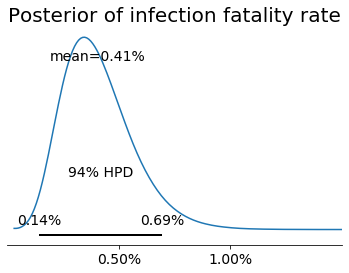

In [8]:
plot_infection_fatality_rate(posterior['infection_fatality_rate'])
plt.title('Posterior of infection fatality rate', fontsize=20);


We find that the mean of the posterior is at 0.41%, very similar but slightly higher than the value reported in the Heinsberg-Study (which reported XY), but that the confident interval is substantially wider (XY to XY) vs (XY to XY). Did our choice of prior cause this bigger confidence interval? To explore this, we ...

NOW DESCRIBE dependence of results on prior






### Estimates of the infection fatality rate for different prior assumptions

## Extrapolating to infection counts in Germany

Can one use knowledge of the IFR in Gangelt to try to estimate the infection count in Germany? If one assumes that the IFR in Germany is the same, and one furthermore assumes that the number of fatalities with Covid-19 is accurately recorded, then one could aim to infer the infection could that would be consistent with these two quantities. Indeed, for a known IFR and fatality-count (and assuming that fatalities are statistically independent), the total infection count is given by a Negative Binomial distribution (see details below)-- we can thus estimate the histogram of infecton counts in Germany by averaging samples from this distribution over the uncertainty in the IFR: 

In [9]:
if os.path.isfile('model1_german_infected.pydat'):
    german_infected = pickle.load(open('model1_german_infected.pydat', 'rb'))
else:
    with model:
        german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(posterior['infection_fatality_rate'])]
    with open('model1_german_infected.pydat', 'wb') as f:
        pickle.dump(german_infected, f)

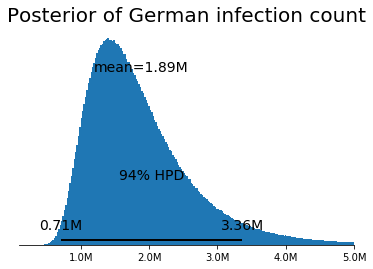

In [10]:
plot_german_infected(german_infected)
plt.title('Posterior of German infection count', fontsize=20);

Using the posterior distribution estimated above, this yields the above histogram-- as we can see, there is a substantial range of infection counts that would be consistent with the data and estimates of the Gangelt study, ranging from 0.7Mio to more than 3 Millions. 

If we use the current number of fatalities in Germany (7824, taken from the [Robert Koch Institut](https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4) as of May 15th, 2020), we can get an updated estimate of the number ofinfections in Germany:

In [11]:
if os.path.isfile('model1_german_infected_updated.pydat'):
    german_infected_updated = pickle.load(open('model1_german_infected_updated.pydat', 'rb'))
else:
    german_infected_updated = [dist.nbinom(n=7824, p=p).rvs() for p in (posterior['infection_fatality_rate'])]

    with open('model1_german_infected_updated.pydat', 'wb') as f:
        pickle.dump(german_infected_updated, f)

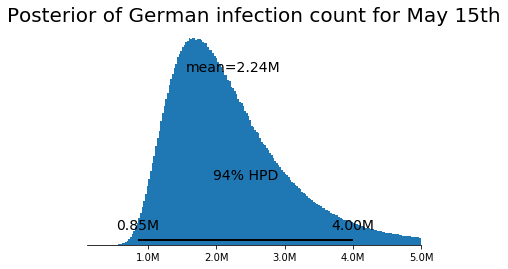

In [12]:
plot_german_infected(german_infected_updated)
plt.title('Posterior of German infection count for May 15th', fontsize=20);

# Discussion

We emphasize that the analysis above rests on several distributional assumptions. These include:

* We assume that the estimation of the infection rate, and its uncertainty by Streeck et al is accurate-- we here did not attempt an Bayesian approach to estimating it, but rather used their estimate in the subsequent analysis. 

* Furthermore, we assumed that a Beta distribution is an appropriate distribution to capture the uncertainty in infection rate. 

* We assume that infections in Gangelt are (conditional on the infection rate) independent from each other.

* Fatalities in Gangelt are (conditional on the fatality rate) independent from each other.

In addition, for any extrapolation to infection-counts in Germany, one would additionally have to assume that:

* both the recorded number of fatalities in Gangelt (Formula) and in Germany (Formula) were accurate, and that

* the infection-fatality rate in Gangelt and in Germany are the same (Formula).

Violation of any of these assumptions, or any combination of them, could have a substantial impact on the results. There are reasonable grounds to challenge several of them, e.g. the assumption that infections occur independenlty from each other, as do fatalities.

We do not take a position on whether these assumptions are appropriate or accurate. However, we would expect that violations of any of these assumptions will generally lead to an increase in the resulting uncertainty. Thus, we would expect that a more conservative analysis (which e.g. models fluctuations in infection rates or statistical dependence in fatalities, e.g. by marginalizing over the associated uncertainty) would likely lead to substantially bigger error bars. 

In addition, we emphasize that the results of any Bayesian analysis depend on the prior distributions assumed. In our case, this is most prominently the case for the prior on the fatality rate. In particular, we showed above that our inference on the posterior distribution over the IFR --- i.e. the error-bars on the IFR--- is manifestly dependent on the prior. One could interpret this dependence on the prior as a weakness of the Bayesian analysis-- however, we do not share this view: It is precisely an advantage of the Bayesian analysis that the dependence of the inferred parameters on prior assumptions is made explicit, and that this dependence can be explored quantitatively. 

When we used a prior that was aimed to capture the range of IFRs prior to the Heinsberg study, we found that the posterior was more concentrated, but not substantially so.  Following the above analysis, one can conclude that the study by Streeck et al only provides weak constraints both on the infection fatality rate in Gangelt, as well as on the extrapolated total infection count in Germany. This is consistent with the naive intuition that any estimation of a fatality rate from a local would depend on a small number of events (here: 7 fatalities), and therefore must necessarily be of limited reliability.

It has been stated that the goal of the Gangelt study was to provide "constraints for models".  As pointed out above, given limited data, no such study would be able to fully constrain parameters-- multiple parameter-settings might be plausible given the available data. This is particularly evident given the very example provided by the example of how these numbers could be used in a "theoretical model" to extrapolate to an infection count in Germany. The results of any such extrapolation would be strongly affected by uncertainty in the underlying parameters. These observations highlight a more general point-- given that it is (rarely) possible to fully constrain any parameter of a model or simulation, it is advisable to not over-interpret simulation-results from any particular model. Rather,  any simulation-results should ideally be interpreted by considering an ensemble of models which are generated from different parameter-sets, each of which is consistent with the observed data (recent methods for simulation-based inference, including our [own work](https://arxiv.org/abs/1905.07488), can be used to directly perform inference over the parameters of numerical simulations). 

Based on the above analysis, the Heinsberg-study, in itself, only provides a weak constraint on the IFR-- however, this does not put into the question the utility of this data: Even weak constraints can be highly valuable, in particularly if they are pooled across multiple studies (as are e.g. are currently underway)-- by combining the results of multiple such studies, one can both aim to more strongly constrain IFRs, as well as to estimate regional variations in IFRs, and have the promise to  Such meta-analyses benefit strongly from openly shared data statistical and analysis-protocols, and have 


# Appendix

In [ ]:
## Detailed definition of model



## Different numbers of fatalities

So far we used a number of seven fatalities in Gangelt, as in the results of the study. However, the paper reports that at least one additional death occured at the very end of the study, other sources even speak of nine deaths. Here we run the model with different numbers of fatalities in Gangelt and see how much this influences results.

In [13]:
if os.path.isfile('model1_fatality_analysis.pydata'):
    fatality_models = pickle.load(open('model1_fatality_analysis.pydata', 'rb'))
else:
    fatality_models = {}

# Run the model for different numbers of fatalities
for fatalities in [5, 6, 7, 8, 9]:
    #print(fatalities)
    if fatalities in fatality_models:
        continue
    with pm.Model() as model:
        # the infection rate is given as 0.1553 [0.1231, 0.1896].
        gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')

        total_population = 12597
        gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')

        infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.1**2), name='infection_fatality_rate')
        gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities', observed=fatalities)
    
        _prior = pm.sample_prior_predictive(samples=50000)
        _posterior = pm.sample(draws=100000)
        
    _german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(_posterior['infection_fatality_rate'])]
    fatality_models[fatalities] = {
        'model': model,
        'prior': _prior,
        'posterior': _posterior,
        'german_infected': _german_infected
    }
    
    with open('model1_fatality_analysis.pydata', 'wb') as f:
        pickle.dump(fatality_models, f)

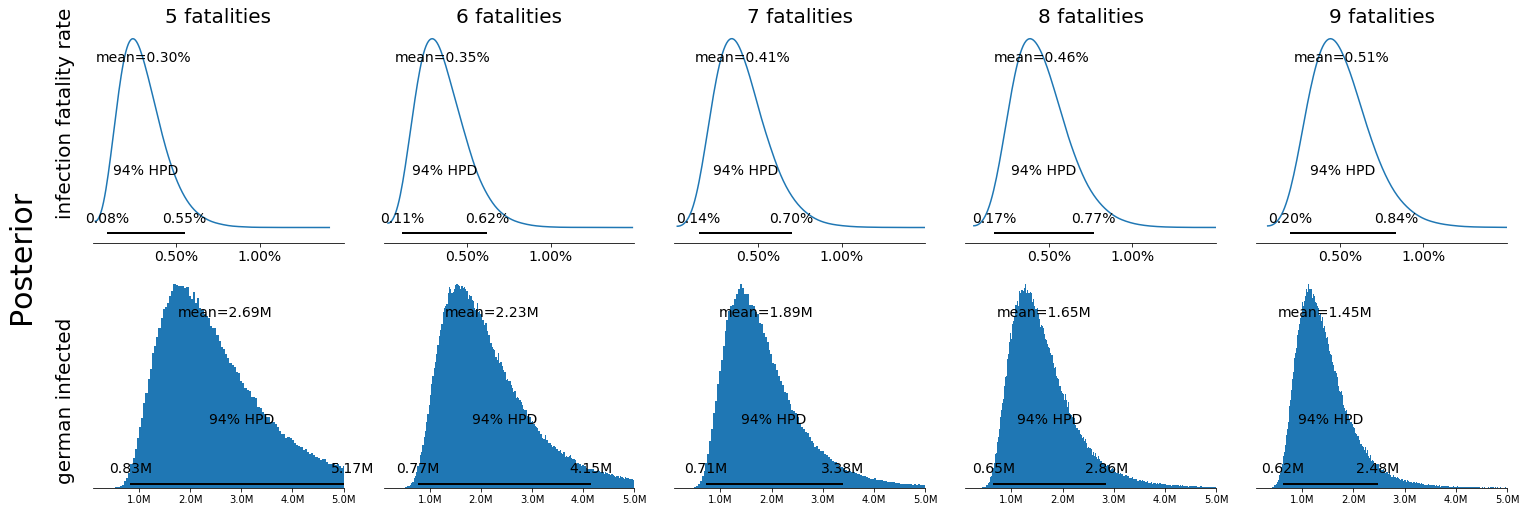

In [15]:
rows = 2
cols = 5
width = 4.5
height = 4

f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))

for model_index, (fatalities, data) in enumerate(fatality_models.items()):
    plot_infection_fatality_rate(data['posterior']['infection_fatality_rate'], ax=axs[0, model_index])
    plot_german_infected(data['german_infected'], ax=axs[1, model_index])
    axs[0, model_index].set_title(f'{fatalities} fatalities', fontsize=20)

plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))

plt.gcf().text(0.04, 1.5/rows, 'infection fatality rate', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 0.5/rows, 'german infected', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.01, 1/rows, 'Posterior', rotation=90, verticalalignment='center', fontsize=30);

## using new number of fatalities in Germany and in Gangelt (8 or 9?).

TODO

## Different IFR priors

TODO

## Comparing beta and uniform priors to model study estimate of the infection rate in Gangelt

TODO